In [14]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.spatial import distance
from distfit import distfit
%matplotlib inline

In [15]:
PD_COUNT = 100

PD_CENTER = 750
PD_SIGMA = 150

PD_DEVIATION_SIGMA = 0.05

In [30]:
def select_pairwise(input_array: np.array) -> np.array:
    x = np.array(np.meshgrid(input_array, input_array)).T.reshape(-1, 2)
    y = np.delete(x, np.arange(0, len(input_array)**2, len(input_array)+1), axis=0)
    return y


def get_deviation(size: int) -> np.array:
    return 1 + np.random.normal(0, PD_DEVIATION_SIGMA, size=size)


def calc_bit_vector_new(pairs: np.array) -> np.array:
    kek = np.hsplit(pairs, 2)
    kek0 = kek[0].flatten() * get_deviation(len(kek[0]))
    kek1 = kek[1].flatten() * get_deviation(len(kek[0]))
    result = (kek0 > kek1).astype(int)
    return result


def generate_propagation_delays(pd_count: int) -> np.array:
    return np.random.normal(PD_CENTER, PD_SIGMA, size=pd_count)


def calc_uniformity(bit_vector: np.array) -> float:
    unique, counts = np.unique(bit_vector, return_counts=True)
    uniformity = counts[1] / bit_vector.size
    return uniformity


def calc_uniformity_normalized(bit_vector: np.array) -> float:
    unique, counts = np.unique(bit_vector, return_counts=True)
    uniformity = 1 - 2 * abs(0.5 - counts[1] / bit_vector.size)
    return uniformity


def calc_reliability(responses: list) -> float:
    ref = responses[0]
    n = len(responses)
    s = 0

    for i in range(1, len(responses)):
        s += distance.hamming(responses[i], ref)

    return 1 - 1 / n * s


def calc_stable(responses: list) -> float:
    s = np.add.reduce(responses)
    mask = (s != 0) & (s != len(responses))
    unique, counts = np.unique(mask, return_counts=True)

    if len(counts) == 1:
        return 1
    else:
        return 1 - counts[1] / len(responses)

In [31]:
def plot_results(res: np.array):
    dfit = distfit(distr="norm")
    dfit.fit_transform(res)
    dfit.plot()


def analyze_stable() -> float:
    pd = generate_propagation_delays(PD_COUNT)

    responses = []
    for _ in range(1000):
        pairs = select_pairwise(pd)
        bit_vector = calc_bit_vector_new(pairs)
        responses.append(bit_vector)

    return calc_stable(responses)


def analyze_unif():
    responses = []
    pd = generate_propagation_delays(PD_COUNT)
    for _ in range(1000):
        pairs = select_pairwise(pd)
        bit_vector = calc_bit_vector_new(pairs)
        responses.append(bit_vector)

    total = np.zeros(len(responses), dtype=np.float32)
    for i in range(len(responses)):
        # total[i] = calc_uniformity(responses[i])
        total[i] = calc_uniformity_normalized(responses[i])

    plot_results(total)


def analyze_reliability(fpga_num: int):
    total = np.zeros(fpga_num, dtype=np.float32)

    for cur_iter in range(fpga_num):
        pd = generate_propagation_delays(PD_COUNT)
        responses = []
        pairs = select_pairwise(pd)

        for i in range(300):
            bit_vector = calc_bit_vector_new(pairs)
            responses.append(bit_vector)

        total[cur_iter] = calc_reliability(responses)

    plot_results(total)


def analyze_uniqueness(fpga_num: int) -> float:
    total = []
    for _ in range(100):
        fpga_resp = []
        for cur_iter in range(fpga_num):
            pd = generate_propagation_delays(PD_COUNT)
            pairs = select_pairwise(pd)
            bit_vector = calc_bit_vector_new(pairs)
            fpga_resp.append(bit_vector)

        total = 0
        for i in range(0, fpga_num - 1):
            for j in range(i + 1, fpga_num):
                total += distance.hamming(fpga_resp[i], fpga_resp[j])

        result = 2 / (fpga_num * (fpga_num - 1)) * total
        total.append(result)

    plot_results(total)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 4106.86] [loc=0.992 scale=0.006]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 4106.86] [loc=0.992 scale=0.006]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.991831, scale:0.005851)


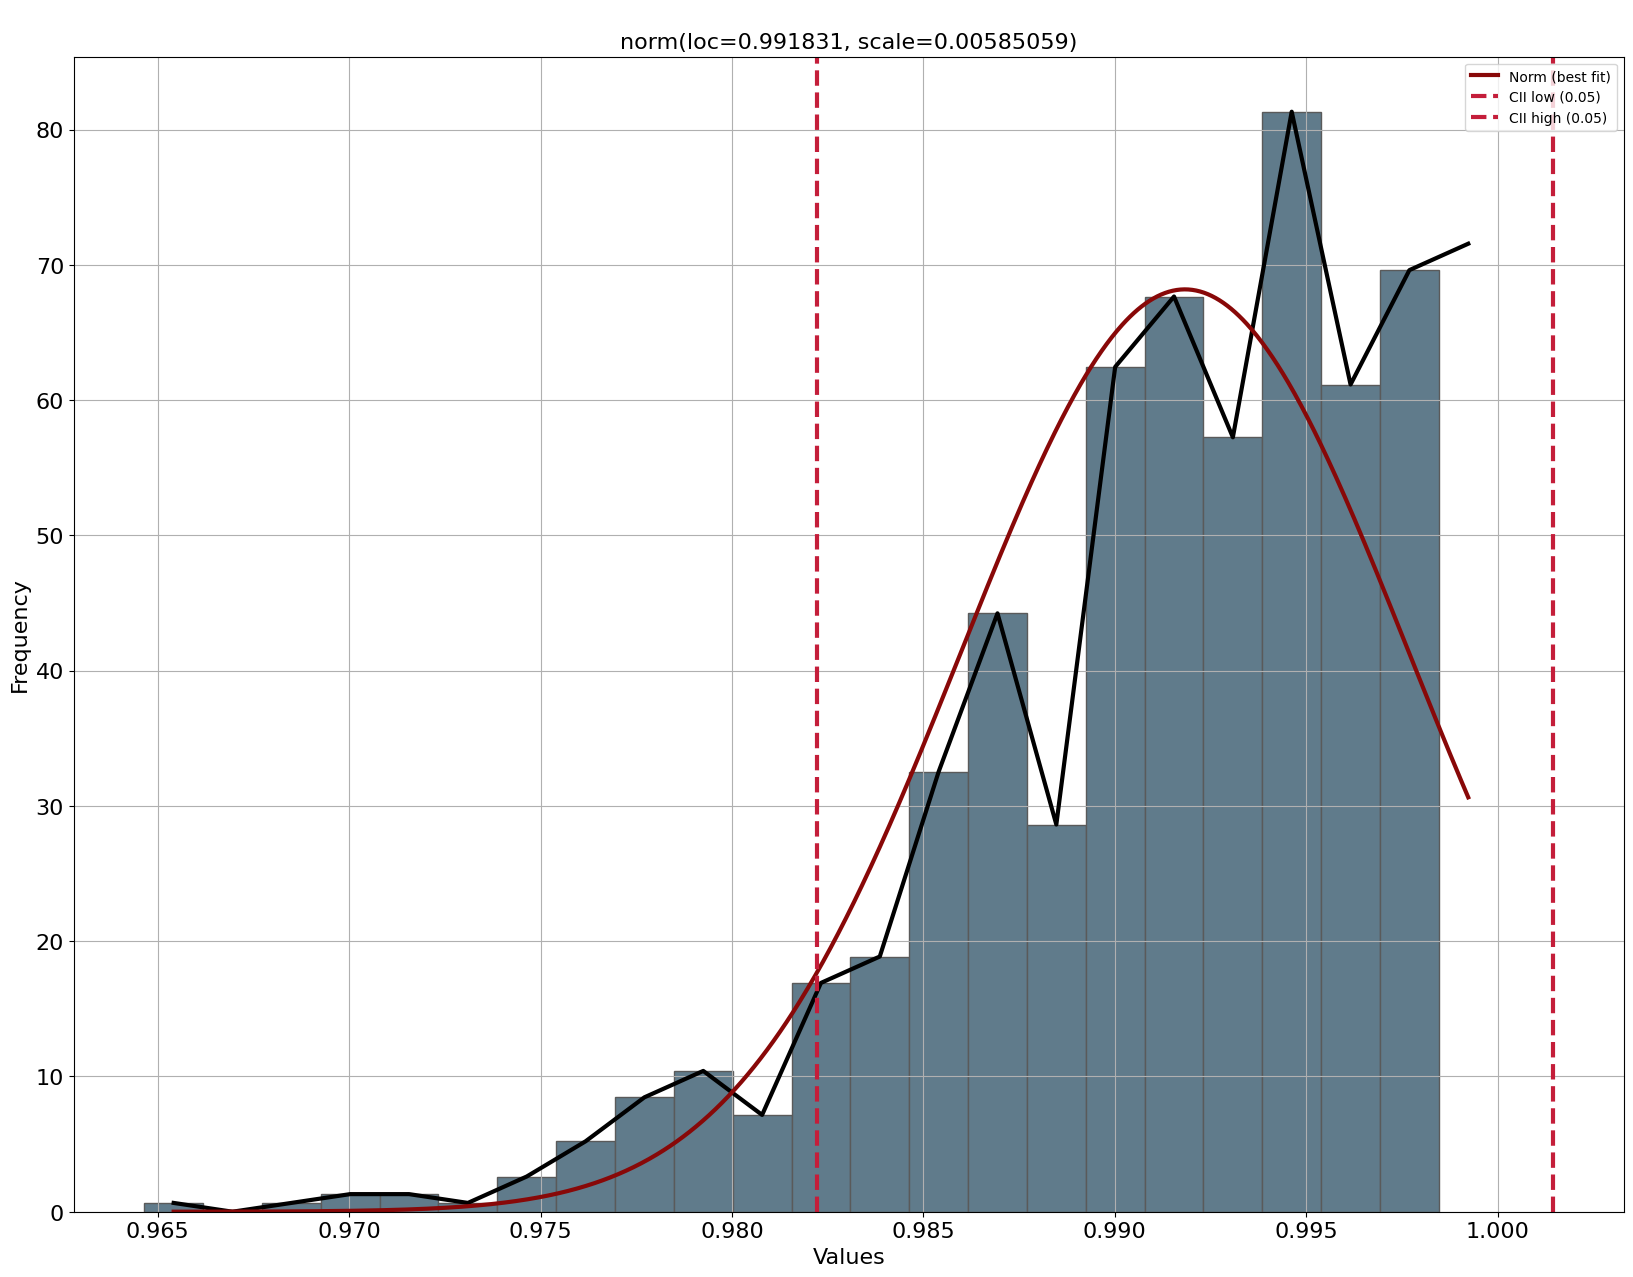

In [32]:
analyze_unif()

In [7]:
# analyze_reliability(50)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 1.01555e+06] [loc=0.500 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 1.01555e+06] [loc=0.500 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.500023, scale:0.000152)


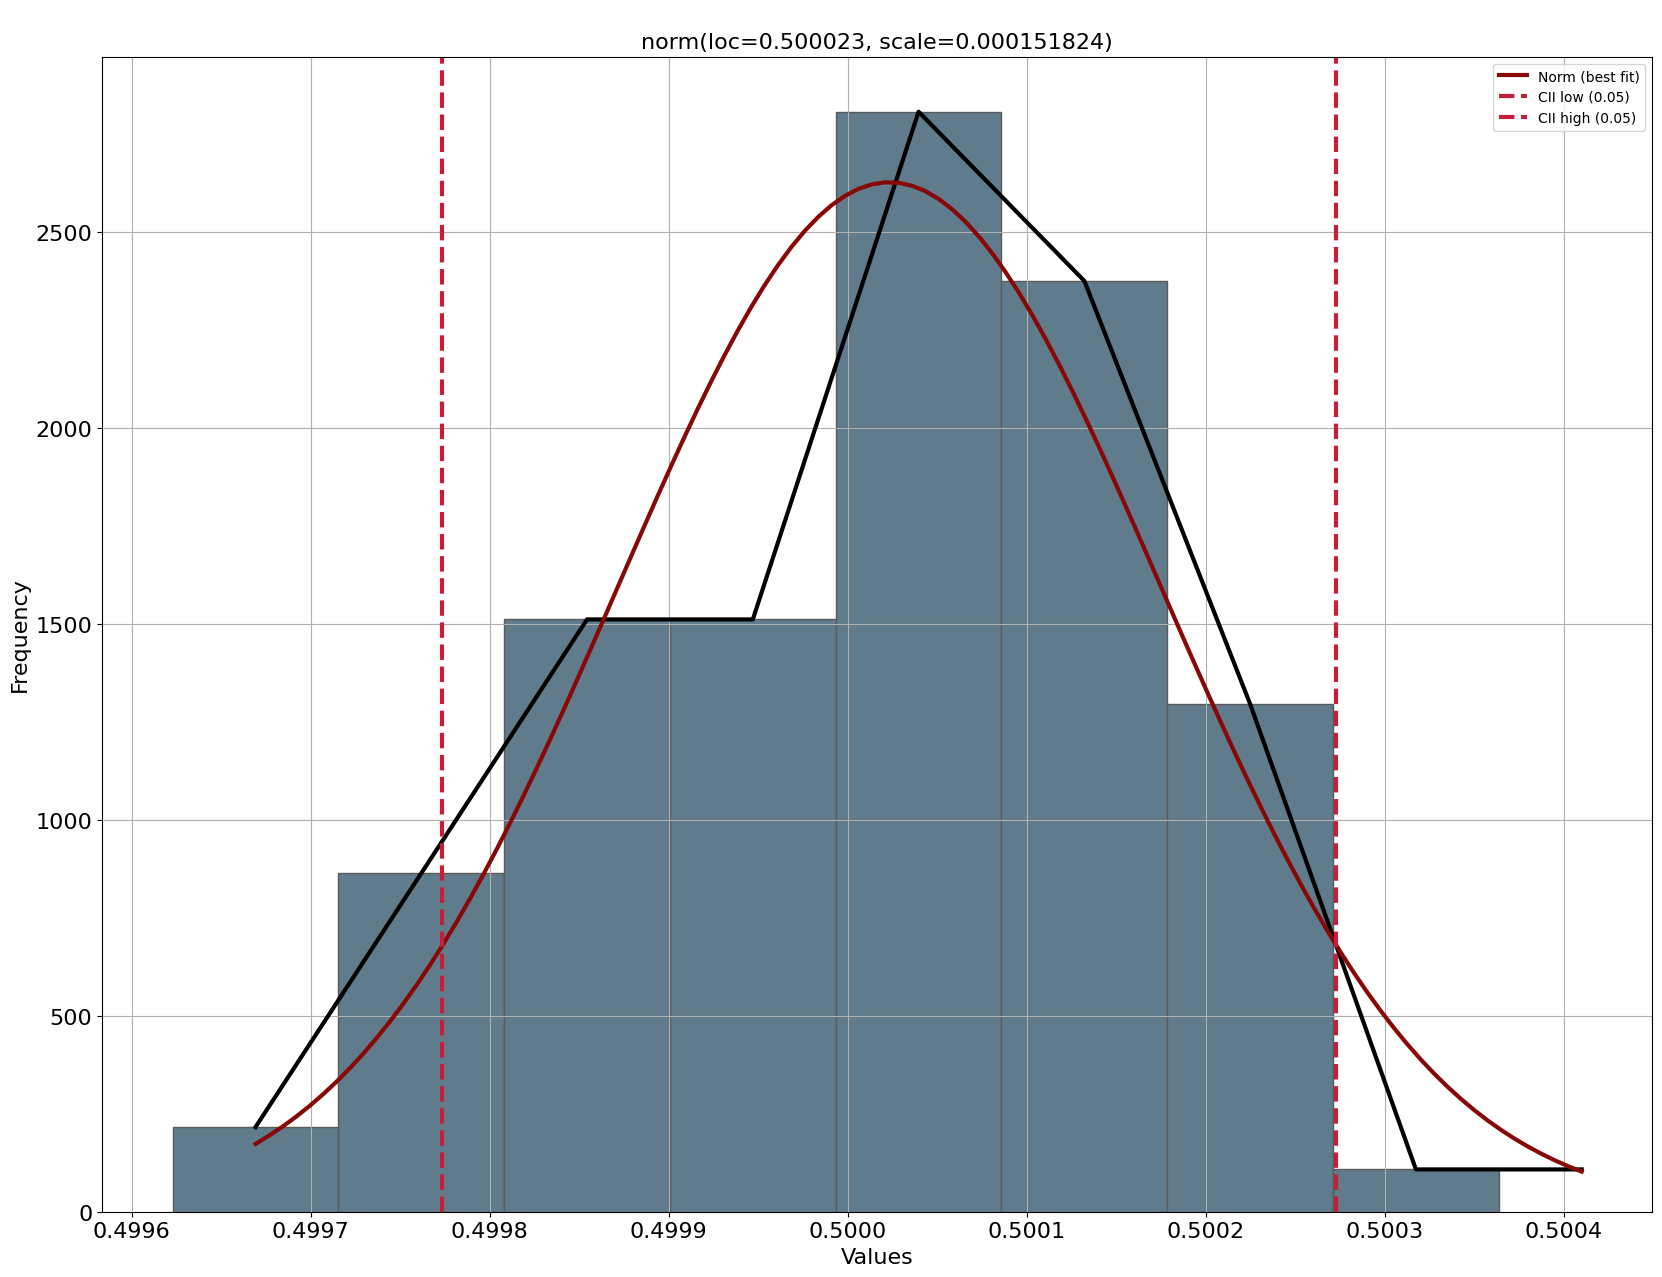

In [8]:
analyze_uniqueness(50)

In [29]:
a = np.array([2, 0, 0, 2])
b = np.array([1, 0, 0, 1])
mask = (a != 0) & (a != 2)
print(mask)
unique, counts = np.unique(mask, return_counts=True)
print(unique, counts)

[False False False False]
[False] [4]


In [33]:
analyze_stable()

1